In [1]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

<h2>Use CUDA</h2>

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# use_cuda = torch.cuda.is_available()
use_cuda = False
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [4]:
import sys
sys.path.append('/home/deepak/Desktop/RL-Adventure-2/')
from common import SubprocVecEnv

num_envs = 16
env_name = "CartPole-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

<h2>Neural Network</h2>

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = F.softmax(self.actor(x))
        dist  = Categorical(probs)
        return dist, value

    def get_logits(self, x):
        logits = self.actor(x)
        return logits[:, 1] - logits[:, 0]

In [6]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    all_states = []
    all_actions = []
    while not done:
        state = torch.FloatTensor(state[1:]).unsqueeze(0).to(device)
        all_states.append(state)

        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        all_actions.append(action)

        next_state, reward, done, _ = env.step(action)
        state = next_state
        if vis:
            env.render()
        total_reward += reward
    return total_reward, all_states, all_actions

In [7]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [8]:
num_inputs  = envs.observation_space.shape[0] - 1
num_outputs = envs.action_space.n

#Hyper params:
hidden_size = 256
lr          = 3e-4
num_steps   = 5

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
model.load_state_dict(torch.load('cartpole-v0-no-pos.dqn.pt', map_location='cpu'))

<All keys matched successfully>

In [9]:
max_frames   = 20000
frame_idx    = 0
test_rewards = []

In [10]:
all_rewards, all_states, all_actions = [], [], []
from tqdm.notebook import tqdm
for _ in tqdm(range(1000)):
    # roll out level
    reward, states, actions = test_env(False)

    all_rewards.append(reward)
    all_states.extend(states)
    all_actions.extend(actions)
    
all_states = torch.concat(all_states, dim=0)
all_states.shape

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_3780/4057391499.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.actor(x))


torch.Size([199834, 3])

Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -2.4 | 2.4
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -0.418 rad (-24&deg;) | ~ 0.418 rad (24&deg;)
3 | Pole Velocity At Tip | -Inf | Inf

In [11]:
from common import Perturber
perturber = Perturber()
delta_out = []
with torch.no_grad():
    for state in tqdm(all_states):
        left_approach, right_approach, pert = perturber.perturb(state)
        left_limit = model.get_logits(left_approach)
        right_limit = model.get_logits(right_approach)
        delta_out.append((right_limit - left_limit) / (2 * pert))

        # original_probs = model.actor()[:, 0]
        # changed_probs = model.actor(perturbed_states)[:, 0]
        # delta_out.append((original_probs - changed_probs) / perturbation)

delta_out = torch.vstack(delta_out)
delta_out.shape

  0%|          | 0/199834 [00:00<?, ?it/s]

torch.Size([199834, 3])

### State vs action
Trained 2 layer FFN (one for actor and one for critic)
100 rollouts were made and average of 187.7 was achieved
Each dimension of state has 2 histograms - grouped by action taken
- position and velocity don't really seem to influence the action taken (histogram is similar)
- model mainly uses theta and omega
  - higher the value, more likely to push right (1)
  - lower the value, more likely to push left (0)

In [12]:
np.mean(all_rewards)

199.834

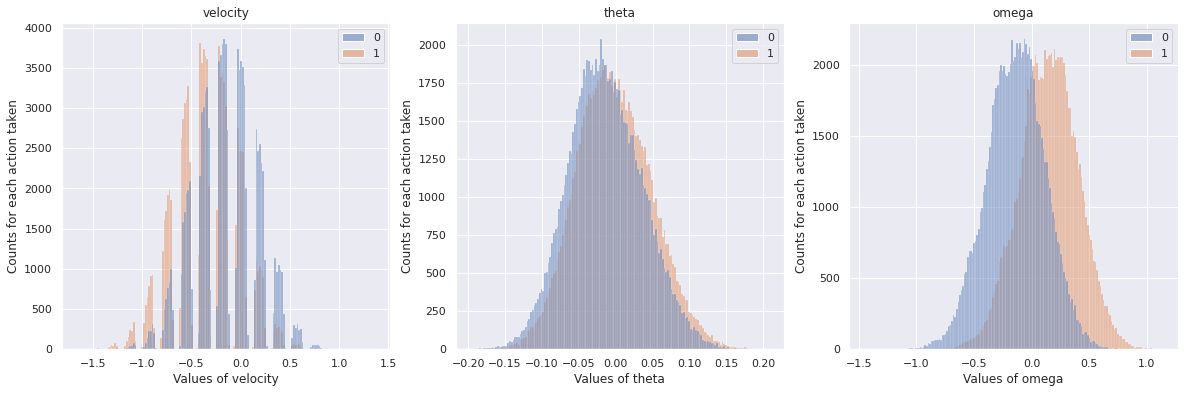

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
names = ['velocity', 'theta', 'omega']
for idx, ax in enumerate(axs):
    values = all_states[:, idx].numpy()
    sns.histplot(x=values, hue=all_actions, ax=ax)
    ax.set_title(names[idx])
    ax.set_xlabel(f'Values of {names[idx]}')
    ax.set_ylabel("Counts for each action taken")

### State vs saliency

In [15]:
import pandas as pd
pd.DataFrame(all_states.numpy(), columns=['velocity', 'theta', 'omega']).agg(['min', 'max'])

,velocity,theta,omega
min,-1.664836,-0.196921,-1.451753
max,1.363551,0.207830,1.138166


In [16]:
cols = ["velocity", "theta", "omega"]
df = pd.DataFrame(
    torch.concat([all_states, delta_out], dim=1).numpy(),
    columns=cols + [x + "_sal" for x in cols],
)

for col in cols:
    df[col+'_bin'] = pd.qcut(df[col], 4)


df.head()

,velocity,theta,omega,velocity_sal,theta_sal,omega_sal,velocity_bin,theta_bin,omega_bin
0,0.025286,0.024299,0.027218,3.869025,7.826869,8.460543,"(-0.00222, 1.364]","(-0.0101, 0.0266]","(0.00569, 0.206]"
1,0.220051,0.024843,-0.257700,4.533155,9.343181,9.123914,"(-0.00222, 1.364]","(-0.0101, 0.0266]","(-1.4529999999999998, -0.196]"
2,0.414810,0.019689,-0.542445,4.876334,8.997796,8.434171,"(-0.00222, 1.364]","(-0.0101, 0.0266]","(-1.4529999999999998, -0.196]"
3,0.219417,0.008840,-0.243624,4.525361,9.328695,9.135908,"(-0.00222, 1.364]","(-0.0101, 0.0266]","(-1.4529999999999998, -0.196]"
4,0.024170,0.003968,0.051834,3.917990,8.243032,8.604496,"(-0.00222, 1.364]","(-0.0101, 0.0266]","(0.00569, 0.206]"


Note that actor output is logit(action=1) (before sigmoid)

- Position:  
   +ve perturbation = moving cart to right (keeping theta, omega, velocity constant)  
   Negative saliency in all the plots => actor wants to keep the cart at the center by moving it left

- Velocity is hard to explain on saliency

- For theta and omega:
 saliency is always positive
    - if theta is increases then actor wants to move cart to right
    - if theta decreases (large negative value) then actor wants to move cart to left




In [ ]:
list(df)

In [17]:
df[["velocity_sal", "theta_sal", "omega_sal"]].mean().reset_index().rename(columns={
    'index': 'feature',
    0: 'saliency_mean'
})


,feature,saliency_mean
0,velocity_sal,4.238636
1,theta_sal,8.813079
2,omega_sal,9.162907


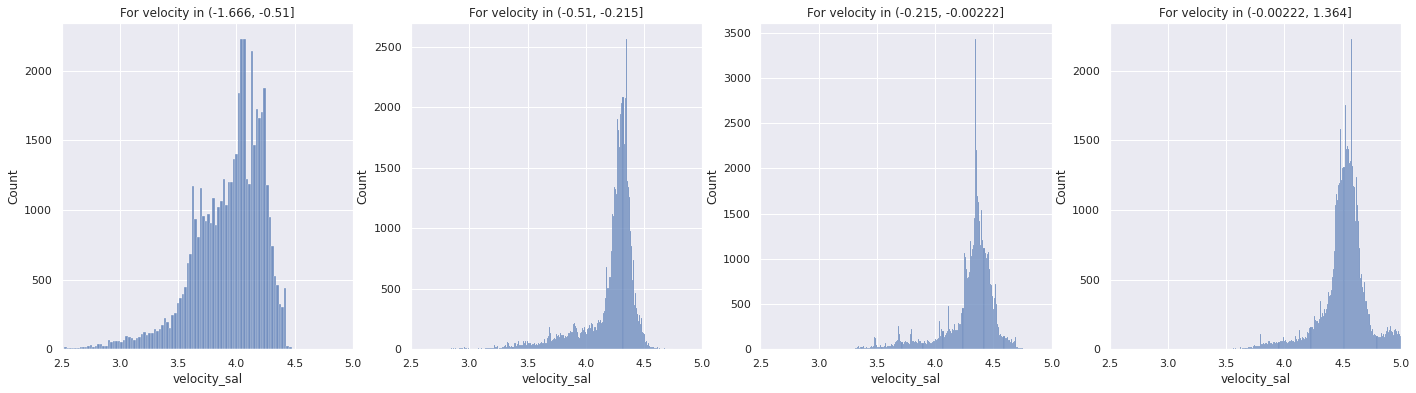

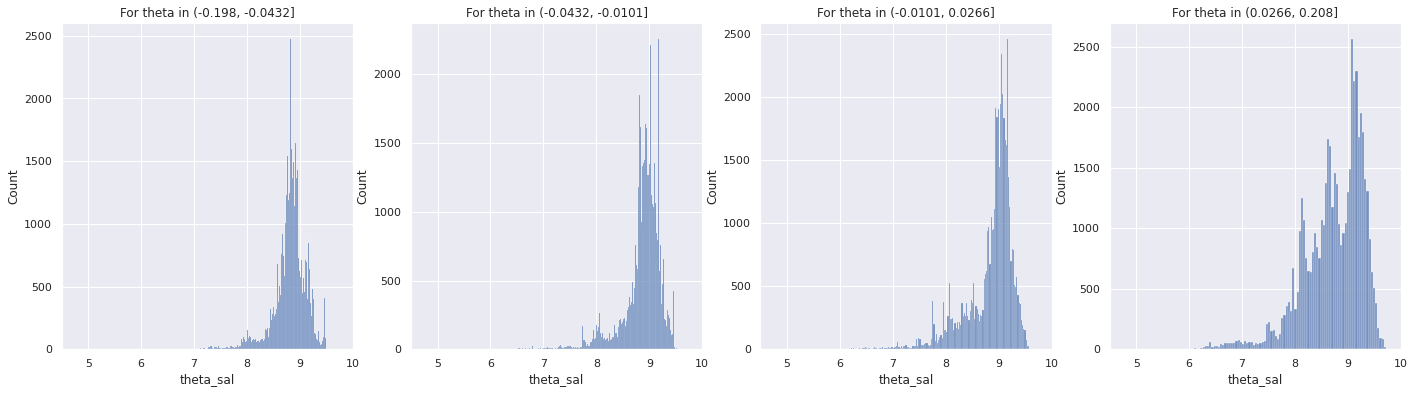

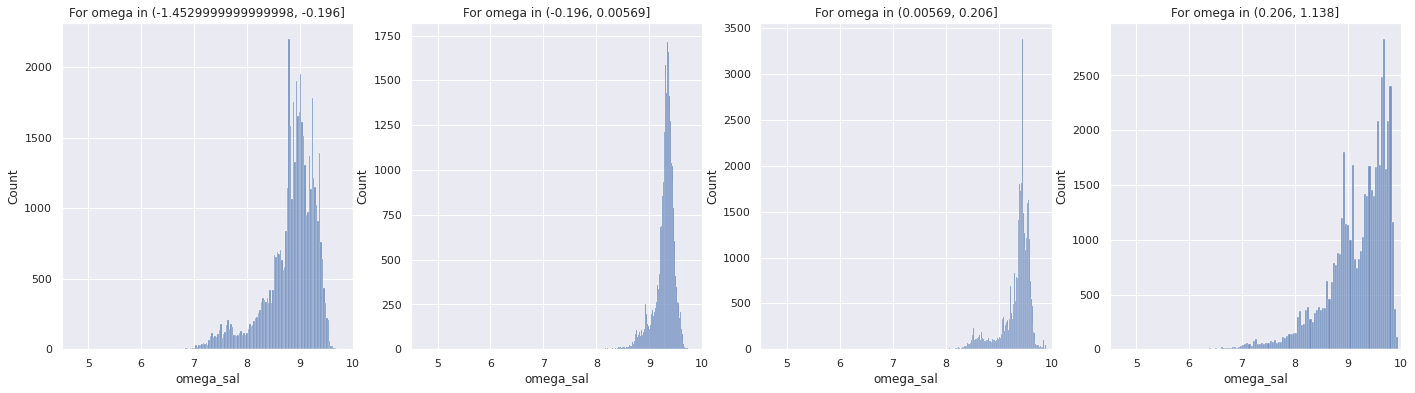

In [18]:
lim_dict = {
    'velocity': [2.5, 5],
    'theta': [4.5, 10],
    'omega': [4.5, 10],
}
for col in cols:
    groups = df.groupby(col+'_bin')
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    for (col_bin, group), ax in zip(groups, axs):
        sns.histplot(data=group, x=col+'_sal', ax=ax)
        ax.set_title(f'For {col} in {col_bin}')
        ax.set_xlim(*lim_dict[col])
    plt.show()